## MONTE CARLO SIMULATION OF CONTACT PROCESS

In [1]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
from numba import jit, prange
import networkx as nx
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from scipy import optimize, stats

In [2]:
@jit(nopython = True)
def init_lattice(N, perc):
    '''
    Returns an initial configuration of size N with N*perc initial infected chosen randomly
    
    INPUTs:
    -size of the lattice
    -percentage of initial infected
    OUTPUTs:
    -linear lattice of length N and N*perc infected nodes
    '''
    #array full of "healthy" nodes
    lattice = np.full(N, 0)
    #get the number of initial infected
    initial_infected = int(N*perc)
    #infect the first nodes and shuffle the array in order to randomize the system
    for i in range(initial_infected): lattice[i] = 1
    np.random.shuffle(lattice)
    return lattice

In [3]:
def plot_lattice(lattice):
    '''
    Plot a lattice
    '''
    fig = plt.figure(figsize = (8, 3))
    N = len(lattice)
    G = nx.grid_2d_graph(N, 1)
    pos = dict( (n, n) for n in G.nodes() )
    colors = np.full(N, ["blue"])

    for i in range(N):
        if lattice[i] == 1: colors[i] = "red"

    legend_elements = [Line2D([0], [0], marker = "o", color="w",label="Scatter",
                                 markerfacecolor = "blue", markersize = 14),
                           Line2D([0], [0], marker="o", color="w", label="Scatter",
                                  markerfacecolor= "red", markersize=14)]
    nx.draw_networkx(G, pos = pos, with_labels = False, labels = None,
                         node_color = colors, node_size = 100)
    #plt.title("Example of initial state", weight = "bold", size = 16)
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.legend(legend_elements, ["Healthy", "Infected"], bbox_to_anchor=(1, 1), loc="upper right", fontsize = 10)
    plt.show()
    fig.savefig("presentazione/Images/CP_init_loc.pdf", transparent=True, bbox_inches = 'tight',
    pad_inches = 0)
    return

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]


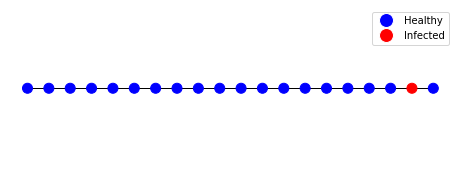

In [27]:
initial_example = init_lattice(20, 1/20)
print(initial_example)
plot_lattice(initial_example)

In [6]:
@jit(nopython = True)
def build_I(lattice):
    '''
    Returns a list with the positions of the infected nodes
    
    INPUT:
    -lattice
    OUTPUT:
    -a list with positions
    '''
    #get the size of the lattice
    N = len(lattice)
    #build a list with a dummy first element in order to have always a list with at least one element (Numba has some problems with empty lists)
    I = np.array([2*N], dtype = np.int64)
    #check infected nodes and add their position to the list
    for n in prange(N):
        if lattice[n] == 1:
            I = np.append(I, n)
    return I

@jit(nopython = True)
def contact(N, I, inf_rate, rec_rate):
    '''
    Performs N trials of infections/recovery
    
    INPUTs:
    -lattice size
    -initial list of infected
    -infection rate
    -recovery rate
    
    OUTPUTs:
    -new list of infected
    '''
    
    
    #recovery probability
    c = rec_rate/(rec_rate + inf_rate)
    #number of initial infected (-1 is necessary because of the first dummy element)
    n_infected = len(I)-1
    
    if n_infected > 0:
        #monte carlo step
        for s in prange(n_infected):
            #get random infected
            i = np.random.randint(1, len(I))
            random_site = I[i]
            
            #we recover it with prob. c
            if np.random.uniform(0., 1.) < c:
                #swap the i-th element with the last and delete the last element of I
                I[i] = I[-1]
                I = I[:-1]
            #otherwise we infect a random neighbor and we add it to the I list
            else: 
                nbrs = [(random_site-1)%N, (random_site+1)%N]
                j = np.random.randint(0, 2)
                random_nbr = nbrs[j]
                if np.any(I == random_nbr)==False:
                        I = np.append(I, random_nbr)
    
    
    return I

@jit(nopython = True)
def trajectory(N, perc, nsteps, inf_rate, rec_rate, surv_prob):
    '''
    Simulates a "trajectory": at each step the lattice is modified
    
    INPUTs:
    -the size of the lattice
    -the percentage of initial infected
    -the number of steps to do
    -infection rate
    -recovery rate
    
    OUTPUTs:
    -a vector with the values of the infected density at each step, including the initial value
    '''
    
    if surv_prob == False:
        #build an initial lattice
        lattice = init_lattice(N, perc)
        #build the list of initial infected
        I = build_I(lattice)
        #build an array to be filled with the infected density at each step
        infected_density = np.zeros(nsteps +1)
        infected_density[0] = perc
        #simulate the contact process and update the infected_density list
        for i in prange(nsteps):
            I = contact(N, I, inf_rate, rec_rate)
            infected_density[i+1] = (len(I)-1)/N
            #stop the simulation if there are no more infected
            if (len(I)-1) == 0: break     

        return infected_density
    
    else:
        #start with one infected node
        perc_1 = 1/N
        lattice = init_lattice(N, perc_1)
        I = build_I(lattice)
        #build an array to be filled with: 1 if there is at least one infected node and 0 otherwise
        surv = np.zeros(nsteps +1)
        surv[0] = 1
        for i in prange(nsteps):
            I = contact(N, I, inf_rate, rec_rate)
            if (len(I)-1) == 0: break
            else: surv[i+1] = 1
        return surv
  
 
@jit(nopython = True)
def simulate(N, perc, ntraj, nsteps, inf_rate, rec_rate= 1, surv_prob= False):
    '''
    Simulates many trajectories
    INPUTs:
    -size of the lattice
    -percentage of initial infected
    -number of trajectories to simulate
    -number of steps per trajectory
    -infection rate
    -recovery rate
    
    OUTPUT:
    matrix with trajectories
    '''
    #matrix with "ntraj" rows and "nsteps + 1" columns
    trajectories = np.zeros((ntraj, nsteps + 1))
    #fill the matrix by rows
    for i in prange(ntraj):
        trajectories[i] = trajectory(N, perc, nsteps, inf_rate, rec_rate, surv_prob)
    
    #trajectories = np.mean(trajectories, axis = 0)
    return trajectories

def find_critical_point1(N, perc, ntraj, nsteps, lower, upper, nintervals, rec_rate = 1, loc = False, surv_prob = False):
    '''
    Gives an estimate of the critical point
    
    INPUTs:
    -size of the lattice
    -percentage of initial infected
    -number of trajectories to simulate
    -number of steps for each trajectory
    -lower bound for the critical point
    -upper bound for the critical point
    -number of points between lower and upper
    -recovery rate
    -bool that is TRUE if we want to simulate with localized i.c. and FALSE otherwise
    -bool that is TRUE if we want to compute the survival probability
    OUTPUTs:
    -list of rates used for the computations
    -list of r_sq for the various regressions
    -list of thetas for the various regressions
    '''
    #build the list of rates to consider for the computation
    rates = np.linspace(lower, upper, nintervals)
    
    if loc == False:
        #build lists to be filled with: delta exponents and r_sq of the regressions
        deltas, r_sq = np.zeros(len(rates)), np.zeros(len(rates))
        for i in range(len(rates)):
            #simulate some trajectories for each rate and get the mean
            sim = simulate(N, perc, ntraj, nsteps, rates[i], 1, surv_prob)
            sim = np.mean(sim, axis = 0)
            if any(sim == 0): continue # skip iteration if absorbing phase is reached (it's not the critical point)
            else: #otherwise perform a linear fit on a double log graph
                x_range = np.log(np.arange(50, nsteps + 1, 1))
                x_range = x_range.reshape(-1,1)
                y_range = np.log(sim[50:])
                model = LinearRegression()
                model.fit(x_range, y_range)
                r_sq[i] = model.score(x_range, y_range)
                deltas[i] = model.coef_*(-1)
        return rates, r_sq, deltas
    else:
        #build lists to be filled with: theta exponents and r_sq of the regressions
        thetas, r_sq = np.zeros(len(rates)), np.zeros(len(rates))
        for i in range(len(rates)):
            #simulate some trajectories for each rate and get the mean
            sim = simulate(N, perc, ntraj, nsteps, rates[i], 1, surv_prob)
            sim = np.mean(sim*N, axis = 0)
            if any(sim == 0): continue
            else:
                x_range = np.log(np.arange(50, nsteps + 1, 1))
                x_range = x_range.reshape(-1,1)
                y_range = np.log(sim[50:])
                model = LinearRegression()
                model.fit(x_range, y_range)
                r_sq[i] = model.score(x_range, y_range)
                thetas[i] = model.coef_
        return rates, r_sq, thetas

In [16]:
rate1 = 2.8
rate2 = 3.2
rate3 = 3.7

N = 10**2

sim1 = simulate(N, 1, 10**3, 10**2, rate1)
sim1 = np.mean(sim1, axis = 0)

sim2 = simulate(N, 1, 10**3, 10**2, rate2)
sim2 = np.mean(sim2, axis = 0)

sim3 = simulate(N, 1, 10**3, 10**2, rate3)
sim3 = np.mean(sim3, axis = 0)

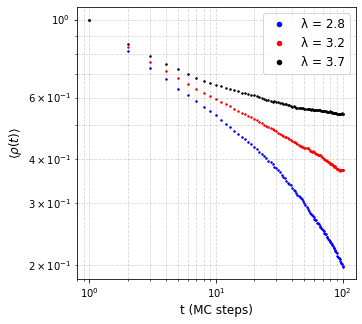

In [17]:
time = np.arange(1, 102, 1)
fig = plt.figure(figsize = (5,5))
plt.plot(time, sim1, marker = ".", markersize = "3", linestyle = "None",
         c = "blue", label = "λ = {}".format(rate1))
plt.plot(time, sim2, marker = ".", markersize = "3", linestyle = "None",
         c = "red", label = "λ = {}".format(rate2))
plt.plot(time, sim3, marker = ".", markersize = "3", linestyle = "None",
         c = "black", label = "λ = {}".format(rate3))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("t (MC steps)", size = 12)
plt.ylabel(r"$\langle ρ(t) \rangle$", size = 12)
#plt.xticks(size = 12)
#plt.yticks(size = 1)
plt.grid(which = "both", alpha = 0.5, linestyle = "--")
plt.legend(markerscale = 3, fontsize =12)
plt.show()
fig.savefig("presentazione/Images/cp/rho_t.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)

## Homogeneous initial conditions

In [33]:
%%time
N = 20
perc = 1
rates, r_sq_10, delta_10 = find_critical_point1(N, perc, 10**4, 10**3, 3.29, 3.32, 5)

i_10 = np.argmax(r_sq_10)
print("Estimated critical point:",  rates[i_10])
print("Relative R_squared:", r_sq_10[i_10])
print("Estimated delta expontnet:", delta_10[i_10])

Estimated critical point: 3.2975
Relative R_squared: 0.9011813373224974
Estimated delta expontnet: 0.8613968533116381
CPU times: user 56 s, sys: 190 ms, total: 56.2 s
Wall time: 55.4 s


In [34]:
%%time
N = 50
perc = 1
rates, r_sq_10, delta_10 = find_critical_point1(N, perc, 10**4, 10**3, 3.29, 3.32, 5)

i_10 = np.argmax(r_sq_10)
print("Estimated critical point:",  rates[i_10])
print("Relative R_squared:", r_sq_10[i_10])
print("Estimated delta expontnet:", delta_10[i_10])

Estimated critical point: 3.2975
Relative R_squared: 0.962542260709981
Estimated delta expontnet: 0.23531636357587202
CPU times: user 3min, sys: 1.47 s, total: 3min 2s
Wall time: 3min 4s


In [35]:
%%time
N = 100
perc = 1
rates, r_sq_10, delta_10 = find_critical_point1(N, perc, 10**4, 10**3, 3.29, 3.32, 5)

i_10 = np.argmax(r_sq_10)
print("Estimated critical point:",  rates[i_10])
print("Relative R_squared:", r_sq_10[i_10])
print("Estimated delta expontnet:", delta_10[i_10])

Estimated critical point: 3.3049999999999997
Relative R_squared: 0.999475010491045
Estimated delta expontnet: 0.1541208806905507
CPU times: user 4min 22s, sys: 1.33 s, total: 4min 23s
Wall time: 4min 24s


In [36]:
print(rates)

[3.29   3.2975 3.305  3.3125 3.32  ]


## $\nu_\parallel$

In [42]:
exp_delta = 0.159
pc = 3.29785
ntraj = 1000
nsteps = 1000
time = np.arange(1, nsteps +1, 1)

rho1 = simulate(100, 1, ntraj, nsteps, 2.8)
rho1 = np.mean(rho1, axis = 0)

rho2 = simulate(100, 1, ntraj, nsteps, 3)
rho2 = np.mean(rho2, axis = 0)

rho3 = simulate(100, 1, ntraj, nsteps, 3.7)
rho3 = np.mean(rho3, axis = 0)

rho4 = simulate(100, 1, ntraj, nsteps, 3.5)
rho4 = np.mean(rho4, axis = 0)

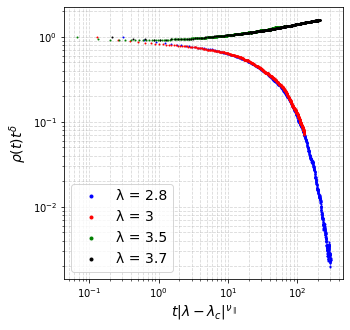

In [45]:
timey = time**exp_delta

y_axis1 = [a*b for a, b in zip(rho1, timey)]
y_axis2 = [a*b for a, b in zip(rho2, timey)]
y_axis3 = [a*b for a, b in zip(rho3, timey)]
y_axis4 = [a*b for a, b in zip(rho4, timey)]

v_par = 1.7

x_axis1 = time*np.abs(2.8-pc)**v_par
x_axis2 = time*np.abs(3-pc)**v_par
x_axis3 = time*np.abs(3.7-pc)**v_par
x_axis4 = time*np.abs(3.5-pc)**v_par

fig = plt.figure(figsize = (5,5))
plt.plot(x_axis1, y_axis1, marker = ".", linestyle = "None", markersize = 2,
         c = "blue", label = "λ = 2.8")
plt.plot(x_axis2, y_axis2, marker = ".", linestyle = "None", markersize = 2,
         c = "red", label = "λ = 3")
plt.plot(x_axis4, y_axis4, marker = ".", linestyle = "None", markersize = 2,
         c = "green", label = "λ = 3.5")
plt.xscale("log")
plt.plot(x_axis3, y_axis3, marker = ".", linestyle = "None", markersize = 2,
         c = "black", label = "λ = 3.7")

#plt.ylim([10**(-3), 10])
plt.yscale("log")
plt.xlabel(r"$t|λ - λ_{c}|^{ν_\parallel}$", size = 14)
plt.ylabel(r"$ρ(t)t^{\delta}$", size = 14)
#plt.title("$ν_\parallel$ = {}".format(v_par), size = 14)
plt.grid(which = "both", alpha = 0.5, linestyle = "--")
plt.legend(markerscale = 3, fontsize = 14)
plt.show()
fig.savefig("presentazione/Images/cp/nu_par_1_7.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)

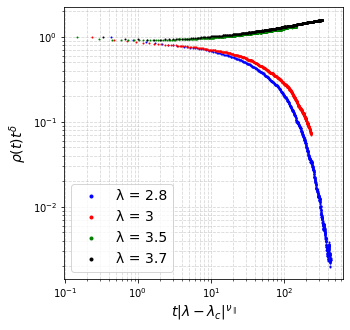

In [46]:
timey = time**exp_delta

y_axis1 = [a*b for a, b in zip(rho1, timey)]
y_axis2 = [a*b for a, b in zip(rho2, timey)]
y_axis3 = [a*b for a, b in zip(rho3, timey)]
y_axis4 = [a*b for a, b in zip(rho4, timey)]

v_par = 1.2

x_axis1 = time*np.abs(2.8-pc)**v_par
x_axis2 = time*np.abs(3-pc)**v_par
x_axis3 = time*np.abs(3.7-pc)**v_par
x_axis4 = time*np.abs(3.5-pc)**v_par

fig = plt.figure(figsize = (5,5))
plt.plot(x_axis1, y_axis1, marker = ".", linestyle = "None", markersize = 2,
         c = "blue", label = "λ = 2.8")
plt.plot(x_axis2, y_axis2, marker = ".", linestyle = "None", markersize = 2,
         c = "red", label = "λ = 3")
plt.plot(x_axis4, y_axis4, marker = ".", linestyle = "None", markersize = 2,
         c = "green", label = "λ = 3.5")
plt.xscale("log")
plt.plot(x_axis3, y_axis3, marker = ".", linestyle = "None", markersize = 2,
         c = "black", label = "λ = 3.7")

#plt.ylim([10**(-3), 10])
plt.yscale("log")
plt.xlabel(r"$t|λ - λ_{c}|^{ν_\parallel}$", size = 14)
plt.ylabel(r"$ρ(t)t^{\delta}$", size = 14)
#plt.title("$ν_\parallel$ = {}".format(v_par), size = 14)
plt.grid(which = "both", alpha = 0.5, linestyle = "--")
plt.legend(markerscale = 3, fontsize = 14)
plt.show()
fig.savefig("presentazione/Images/cp/nu_par_1_2.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)

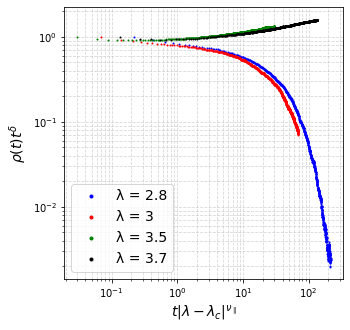

In [47]:
timey = time**exp_delta

y_axis1 = [a*b for a, b in zip(rho1, timey)]
y_axis2 = [a*b for a, b in zip(rho2, timey)]
y_axis3 = [a*b for a, b in zip(rho3, timey)]
y_axis4 = [a*b for a, b in zip(rho4, timey)]

v_par = 2.2

x_axis1 = time*np.abs(2.8-pc)**v_par
x_axis2 = time*np.abs(3-pc)**v_par
x_axis3 = time*np.abs(3.7-pc)**v_par
x_axis4 = time*np.abs(3.5-pc)**v_par

fig = plt.figure(figsize = (5,5))
plt.plot(x_axis1, y_axis1, marker = ".", linestyle = "None", markersize = 2,
         c = "blue", label = "λ = 2.8")
plt.plot(x_axis2, y_axis2, marker = ".", linestyle = "None", markersize = 2,
         c = "red", label = "λ = 3")
plt.plot(x_axis4, y_axis4, marker = ".", linestyle = "None", markersize = 2,
         c = "green", label = "λ = 3.5")
plt.xscale("log")
plt.plot(x_axis3, y_axis3, marker = ".", linestyle = "None", markersize = 2,
         c = "black", label = "λ = 3.7")

#plt.ylim([10**(-3), 10])
plt.yscale("log")
plt.xlabel(r"$t|λ - λ_{c}|^{ν_\parallel}$", size = 14)
plt.ylabel(r"$ρ(t)t^{\delta}$", size = 14)
#plt.title("$ν_\parallel$ = {}".format(v_par), size = 14)
plt.grid(which = "both", alpha = 0.5, linestyle = "--")
plt.legend(markerscale = 3, fontsize = 14)
plt.show()
fig.savefig("presentazione/Images/cp/nu_par_2_2.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)

## $z$

In [7]:
ntraj = 10000
nsteps = 2000
time = np.arange(1, nsteps +1, 1)

rho1 = simulate(10, 1, ntraj, nsteps, 3.28)
rho1 = np.mean(rho1, axis = 0)

rho2 = simulate(20, 1, ntraj, nsteps, 3.28)
rho2 = np.mean(rho2, axis = 0)

rho3 = simulate(30, 1, ntraj, nsteps, 3.28)
rho3 = np.mean(rho3, axis = 0)

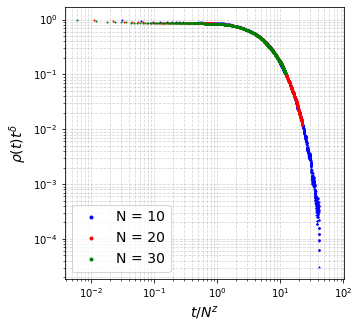

In [9]:
exp_delta = 0.159
pc = 3.29785
timey = time**exp_delta
time1 = np.arange(1, nsteps +1, 1)

y_axis1 = [a*b for a, b in zip(rho1, timey)]
y_axis2 = [a*b for a, b in zip(rho2, timey)]
y_axis3 = [a*b for a, b in zip(rho3, timey)]

z = 1.5

x_axis1 = time/(10**z)
x_axis2 = time/(20**z)
x_axis3 = time/(30**z)

fig = plt.figure(figsize = (5,5))
plt.plot(x_axis1, y_axis1, marker = ".", linestyle = "None",
         markersize = 2, c = "blue", label = "N = 10")
plt.plot(x_axis2, y_axis2, marker = ".", linestyle = "None",
         markersize = 2, c = "red", label = "N = 20")
plt.plot(x_axis3, y_axis3, marker = ".", linestyle = "None",
         markersize = 2, c = "green", label = "N = 30")
plt.ylabel(r"$ρ(t)t^{\delta}$", size = 14)
plt.xlabel(r"$t/N^z$", size = 14)
#plt.title("z = {}".format(z))
plt.xscale("log")
plt.yscale("log")
plt.grid(which = "both", alpha = 0.5, linestyle = "--")
plt.legend(markerscale = 3, fontsize = 14)
plt.show()
fig.savefig("presentazione/Images/cp/z_1_5.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)
#plt.ylim([10**(-4), 10])

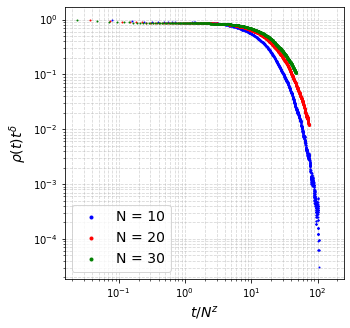

In [10]:
timey = time**exp_delta
time1 = np.arange(1, nsteps +1, 1)

y_axis1 = [a*b for a, b in zip(rho1, timey)]
y_axis2 = [a*b for a, b in zip(rho2, timey)]
y_axis3 = [a*b for a, b in zip(rho3, timey)]

z = 1.1

x_axis1 = time/(10**z)
x_axis2 = time/(20**z)
x_axis3 = time/(30**z)

fig = plt.figure(figsize = (5,5))
plt.plot(x_axis1, y_axis1, marker = ".", linestyle = "None",
         markersize = 2, c = "blue", label = "N = 10")
plt.plot(x_axis2, y_axis2, marker = ".", linestyle = "None",
         markersize = 2, c = "red", label = "N = 20")
plt.plot(x_axis3, y_axis3, marker = ".", linestyle = "None",
         markersize = 2, c = "green", label = "N = 30")
plt.ylabel(r"$ρ(t)t^{\delta}$", size = 14)
plt.xlabel(r"$t/N^z$", size = 14)
#plt.title("z = {}".format(z))
plt.xscale("log")
plt.yscale("log")
plt.grid(which = "both", alpha = 0.5, linestyle = "--")
plt.legend(markerscale = 3, fontsize = 14)
plt.show()
fig.savefig("presentazione/Images/cp/z_1_1.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)
#plt.ylim([10**(-4), 10])

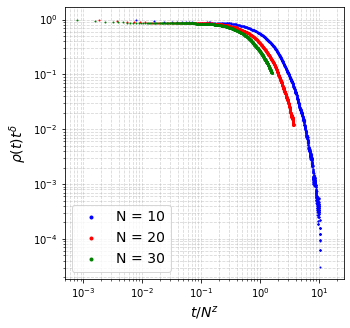

In [11]:
timey = time**exp_delta
time1 = np.arange(1, nsteps +1, 1)

y_axis1 = [a*b for a, b in zip(rho1, timey)]
y_axis2 = [a*b for a, b in zip(rho2, timey)]
y_axis3 = [a*b for a, b in zip(rho3, timey)]

z = 2.1

x_axis1 = time/(10**z)
x_axis2 = time/(20**z)
x_axis3 = time/(30**z)

fig = plt.figure(figsize = (5,5))
plt.plot(x_axis1, y_axis1, marker = ".", linestyle = "None",
         markersize = 2, c = "blue", label = "N = 10")
plt.plot(x_axis2, y_axis2, marker = ".", linestyle = "None",
         markersize = 2, c = "red", label = "N = 20")
plt.plot(x_axis3, y_axis3, marker = ".", linestyle = "None",
         markersize = 2, c = "green", label = "N = 30")
plt.ylabel(r"$ρ(t)t^{\delta}$", size = 14)
plt.xlabel(r"$t/N^z$", size = 14)
#plt.title("z = {}".format(z))
plt.xscale("log")
plt.yscale("log")
plt.grid(which = "both", alpha = 0.5, linestyle = "--")
plt.legend(markerscale = 3, fontsize = 14)
plt.show()
fig.savefig("presentazione/Images/cp/z_2_1.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)
#plt.ylim([10**(-4), 10])

## Localized initial conditions

In [63]:
%%time
N = 1000
perc = 1/N
rates, r_sq_10, theta_10 = find_critical_point1(N, perc, 10**4, 10**3, 3.29, 3.32, 5, loc = True)

i_10 = np.argmax(r_sq_10)
print("Estimated critical point:",  rates[i_10])
print("Relative R_squared:", r_sq_10[i_10])
print("Estimated theta exponent:", theta_10[i_10])

Estimated critical point: 3.2975
Relative R_squared: 0.9995100919440325
Estimated theta exponent: 0.3057713431120477
CPU times: user 5min 4s, sys: 2.53 s, total: 5min 6s
Wall time: 5min 15s


In [77]:
%%time
N = 5000
perc = 1/N
rates, r_sq_10, delta_10 = find_critical_point1(N, perc, 10**4, 10**3, 3.29, 3.32, 5, loc = True)

i_10 = np.argmax(r_sq_10)
print("Estimated critical point:",  rates[i_10])
print("Relative R_squared:", r_sq_10[i_10])
print("Estimated delta expontnet:", delta_10[i_10])

Estimated critical point: 3.3125
Relative R_squared: 0.9992911450855456
Estimated delta expontnet: 0.33703493612126484
CPU times: user 5min 20s, sys: 2.39 s, total: 5min 23s
Wall time: 5min 30s


In [76]:
%%time
N = 10000
perc = 1/N
rates, r_sq_10, delta_10 = find_critical_point1(N, perc, 10**4, 10**3, 3.29, 3.32, 5, loc = True)

i_10 = np.argmax(r_sq_10)
print("Estimated critical point:",  rates[i_10])
print("Relative R_squared:", r_sq_10[i_10])
print("Estimated delta expontnet:", delta_10[i_10])

Estimated critical point: 3.2975
Relative R_squared: 0.9994056406139156
Estimated delta expontnet: 0.3100760570808842
CPU times: user 5min 30s, sys: 2.35 s, total: 5min 32s
Wall time: 5min 37s


In [78]:
a = simulate(10000, 1/10000, 20000, 1000, 3.29785, rec_rate = 1, surv_prob = False)
a = np.mean(a*10000, axis = 0)

In [83]:
x_range = np.log(np.arange(80, 1000 + 1, 1))
x_range = x_range.reshape(-1,1)
y_range = np.log(a[80:])
model = LinearRegression()
model.fit(x_range, y_range)
print(model.score(x_range, y_range))
print(model.coef_)

0.9994929756489521
[0.3111207]


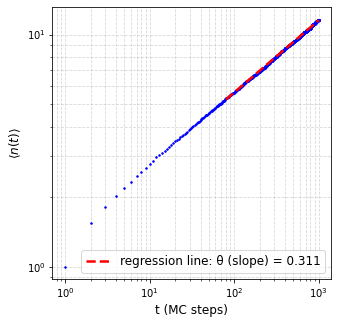

In [109]:
fig = plt.figure(figsize = (5,5))
plt.plot(range(1, 1002),a, marker = ".", markersize = 3, linestyle = "None",
         c= "blue")#, label = "θ (slope) = {}".format(round(model.coef_[0],3)))
plt.plot(range(80, 1002), range(80, 1002)**(model.coef_)*np.exp(model.intercept_),
         c = "red", linestyle = "--", linewidth = 2.5, label = "regression line: θ (slope) = {}".format(round(model.coef_[0],3)))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("t (MC steps)", size = 12)
plt.ylabel(r"$\langle n(t) \rangle$", size = 12)
plt.grid(which = "both", alpha = 0.5, linestyle = "--")
plt.legend(fontsize = 12)
#plt.text(1, 10, "ciao")
plt.show()
fig.savefig("presentazione/Images/cp/theta.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)

fig = plt.figure(figsize = (5,5))
plt.plot(range(1, 1002),a, marker = ".", markersize = 3, linestyle = "None", c= "blue", markerfacecolor = "white")
plt.plot(range(10, 1002), range(10, 1002)**(model.coef_)*np.exp(model.intercept_),
         c = "red", linestyle = "--", linewidth = 1,
         label = "regression line: θ (slope) = {}".format(round(model.coef_[0],3)))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("t (MC steps)", size = 12)
plt.ylabel("n(t)", size = 12)
plt.grid(which = "both", alpha = 0.5, linestyle = "--")
plt.legend(fontsize = 12)
plt.show()
fig.savefig("presentazione/Images/theta_reg.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)

In [15]:
a = simulate(10000, 1/10000, 20000, 1000, 3.29785, rec_rate = 1, surv_prob = True)
a = np.mean(a, axis = 0)

In [16]:
x_range = np.log(np.arange(10, 1000 + 1, 1))
x_range = x_range.reshape(-1,1)
y_range = np.log(a[10:])
model = LinearRegression()
model.fit(x_range, y_range)
print(model.score(x_range, y_range))
print(model.coef_*(-1))

0.9997175834118089
[0.1587783]


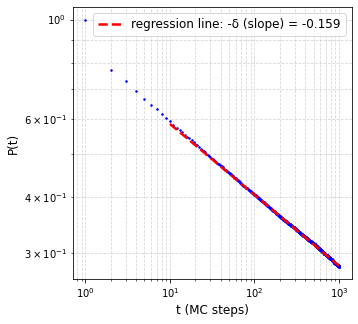

In [17]:
fig = plt.figure(figsize = (5,5))
plt.plot(range(1, 1002),a, marker = ".", markersize = 3, linestyle = "None",
         c= "blue")#, label = "δ (slope) = {}".format(round(model.coef_[0]*(-1),3)))
plt.plot(range(10, 1002), range(10, 1002)**(model.coef_)*np.exp(model.intercept_),
         c = "red", linewidth = 2.5, linestyle = "--", label = "regression line: -δ (slope) = {}".format(round(model.coef_[0],3)))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("t (MC steps)", size = 12)
plt.ylabel("P(t)", size = 12)
plt.grid(which = "both", alpha = 0.5, linestyle = "--")
plt.legend(fontsize = 12)
plt.show()
fig.savefig("presentazione/Images/cp/delta.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)